## Import relevant libraries

In [1]:
import pydicom
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from skimage.feature import canny
from skimage.filters import gaussian 
from scipy.ndimage import zoom
import skimage.morphology as morph
from skimage import measure
import trimesh
from skimage.measure import label   

## Import the data

In [2]:
# A function that create a list of all the images of a specipic patient 
def import_patient(patient_num):
    if (patient_num<=9):
        folder = r"C:\Users\USER\Desktop\Image Processing Project\FUMPE\CT_scans\PAT00" + str(patient_num)
    else: 
        folder = r"C:\Users\USER\Desktop\Image Processing Project\FUMPE\CT_scans\PAT0" + str(patient_num)
    filenames = os.listdir(folder)
    
    # Correction of Uint16 to the units accepted in CT scans- "Hounsfield scale"
    dcm = pydicom.dcmread(folder + '\\' + filenames[0])
    intercept = float(dcm.RescaleIntercept)
    slope = float(dcm.RescaleSlope)
    images = [pydicom.dcmread(folder + '\\' + fn).pixel_array*slope + intercept for fn in filenames]
    
    # Sort the list of images by order to be able to create a correct volume
    z_coords = [pydicom.dcmread(folder + '\\' + fn).ImagePositionPatient[2] for fn in filenames]
    sorted_indices = np.argsort(z_coords)
    sorted_images = [images[i] for i in sorted_indices]

    return dcm, sorted_images

In [3]:
# A function that create a volume of a specific patient 
def create_volume(patient_num):
    dcm, sorted_images = import_patient(patient_num)
    
    # Correcting the images sizes according to the pixel values of each image
    p_s = dcm.PixelSpacing
    pixel_spacing = [float(p_s[0]), float(p_s[1]), 1.0]
    
    # Create a volume 
    vol = np.stack(sorted_images, axis=2)
    
    # Normalization of the volume so that they are the right size 
    rescaled_vol = zoom(vol, pixel_spacing, order=1)
    
    return rescaled_vol

In [4]:
# The images size is (512,512), grayscales 
dcm, sorted_images= import_patient(1)
sorted_images[0].shape

(512, 512)

In [5]:
# The volume size is (317, 317, 201)
rescaled_vol= create_volume(1)
rescaled_vol.shape

(317, 317, 201)

In [6]:
# Show the sum of the volume in different axis in gray colors
def show_volume2D(vol):
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(np.sum(vol, axis=0), cmap = 'gray')
    plt.title('Front view (axis 0)', fontsize=12)
    plt.subplot(1,3,2)
    plt.imshow(np.sum(vol, axis=1), cmap = 'gray')
    plt.title('Side view (axis 1)', fontsize=12)
    plt.subplot(1,3,3)
    plt.imshow(np.sum(vol, axis=2), cmap = 'gray')
    plt.title('Upper view (axis 2)', fontsize=12)
    plt.show()

In [7]:
# A function that export the 3-D volume to stl file
def show_volume3D(vol, name):
    #verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True)
    verts, faces, _, _ = measure.marching_cubes(vol, 0)
    #verts, faces = measure.marching_cubes_classic(vol, 0)
    mesh = trimesh.Trimesh(vertices=verts, faces=faces)
    path = r'C:\Users\USER\Desktop\Image Processing Project\vol_' + str(name) + '.stl'
    _ = trimesh.exchange.export.export_mesh(mesh, path)

## Sigmentation on a single image (not volume)

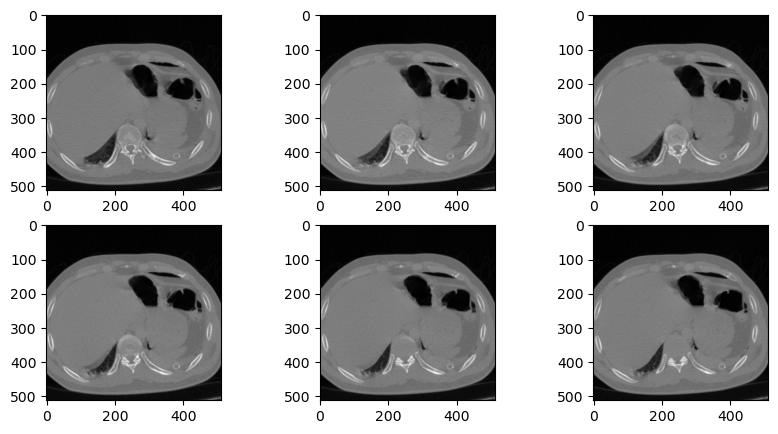

In [8]:
# Creating a list of "dicom" images
dcm, sorted_images = import_patient(1)

# Show the first 6 normalized images, for axample
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sorted_images[i], cmap='gray')

### Algorithm 1- Simple sigmentation with threshold

In [9]:
# A function that normalize an image
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

In [10]:
# Normalizing all the images
images_norm = [normalize(img) for img in sorted_images]
img_norm = images_norm[0]

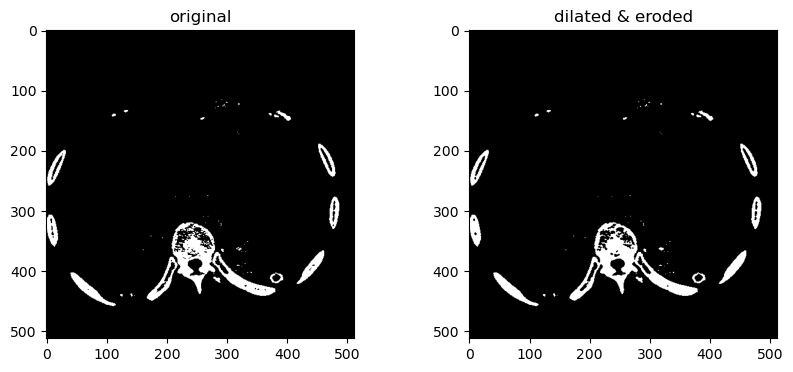

In [11]:
# Find the right threshold to seperate the rib cage
img_norm_th = img_norm > 0.53

# Dilated & erosion to connect all the bones
img_dilated = morph.dilation(img_norm_th)
img_eroded = morph.erosion(img_dilated)

# Show before and after the morphology
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_norm_th, cmap='gray')
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(img_eroded, cmap='gray')
plt.title('dilated & eroded')
plt.show()

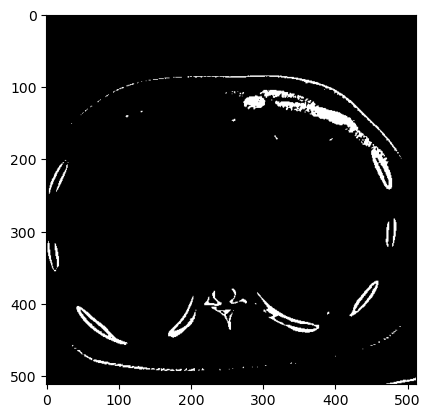

In [12]:
# Sharpening the images by gaussian
img_sharping = img_norm - gaussian(img_norm, sigma= 50)

# Sigmentation the bones by threshold
plt.imshow(img_sharping>0.22, cmap = 'gray')
plt.show()

### Algorithm 2- Canny method

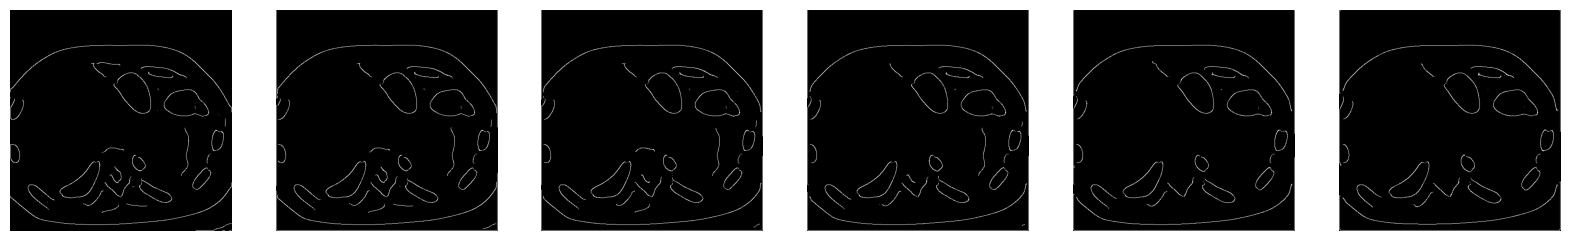

In [13]:
# Create a single image
img = sorted_images[0]

# Gaussian filter that blurs the image and reduces noises
img_gaussian = gaussian(img, sigma=10)

# Canny method on a few sigma options (1-6)
n = 6
plt.figure(figsize=(20, 4))
for i, canny_sigma in enumerate(range(n), start=1):
    plt.subplot(1, n, i)
    canny_edge_img = canny(image=img_gaussian, sigma=canny_sigma, low_threshold=0, high_threshold=0.55, use_quantiles= True)
    plt.imshow(canny_edge_img, cmap='gray')
    plt.axis('off')
plt.show()

## Sigmentation on a volume

#### Step 1- Create & Show volume 

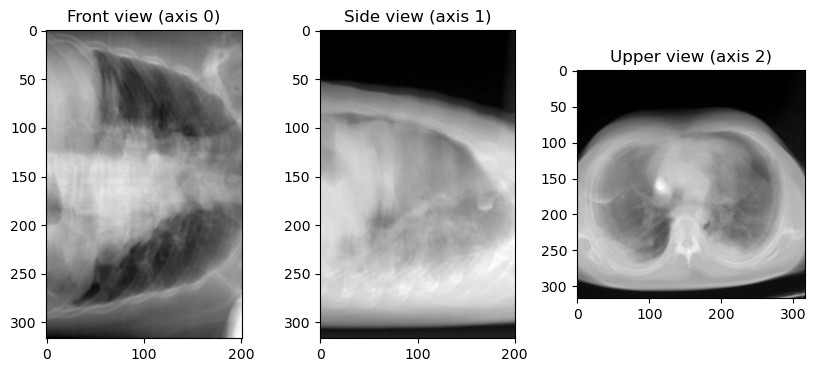

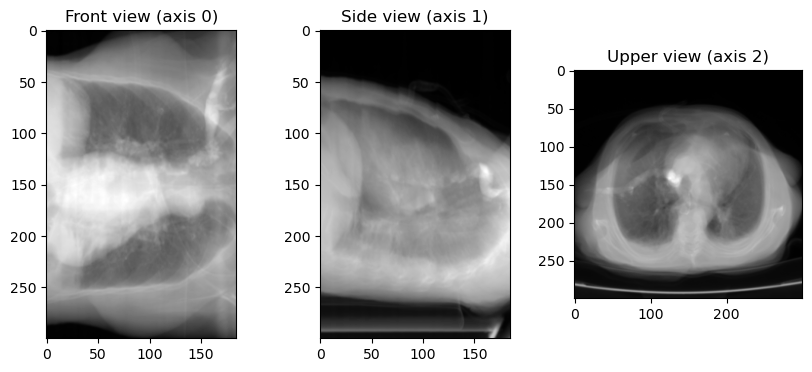

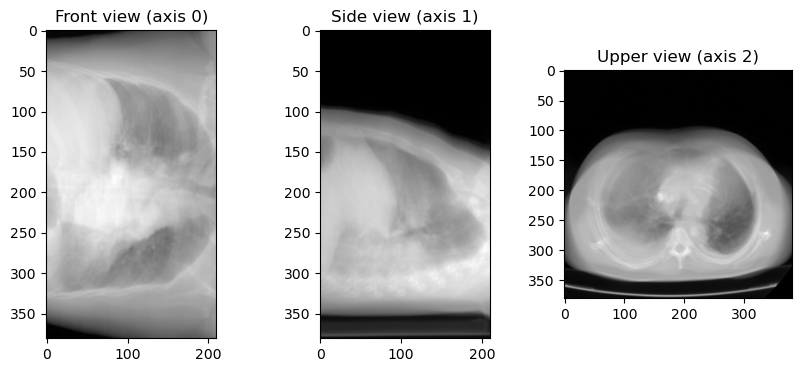

In [14]:
# Show the sum volume (2D) of 3 different patients, for axample
for i in range(1,4): 
    vol = create_volume(i)
    show_volume2D(vol)

In [15]:
# Create a volume of patient number 1 & show on 3-D
vol1 = create_volume(1)
show_volume3D(vol1, '1')

#### Step 2- Filter only the bons on the different axis

In [16]:
# Bones scales by Hounsfield scale values, is between 400 to 500 and 500 to 1900.
def bones_sigmentation(volume):
    bones_scale_vol = ((volume >= 300) & (volume <= 400)) | ((volume >= 500) & (volume <= 1900))
    return bones_scale_vol

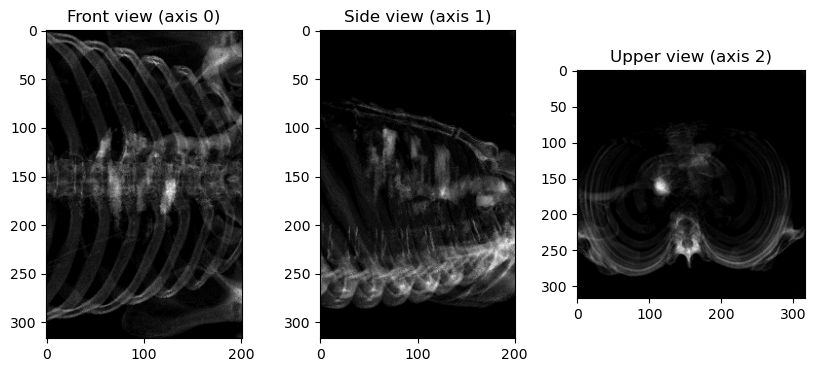

In [17]:
bones_scale_vol1 = bones_sigmentation(vol1)
show_volume2D(bones_scale_vol1)
show_volume3D(bones_scale_vol1, 'Only_Bones_2')

#### Step 3- Removing noises by hand

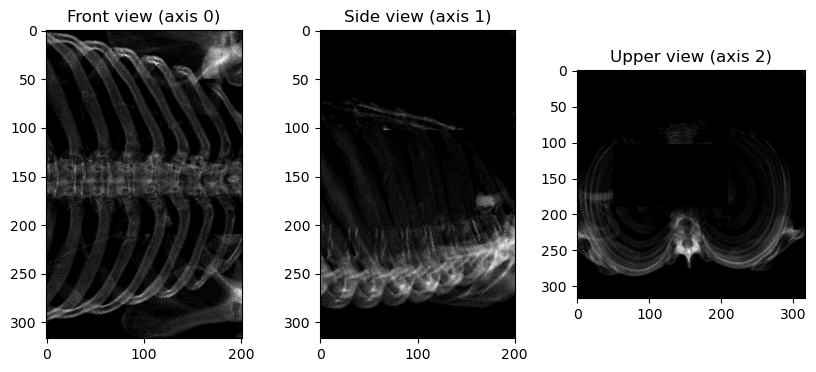

In [18]:
# Slicing the noise by hand
bones_scale_vol_slicing = bones_scale_vol1.copy()
bones_scale_vol_slicing[103:190,50:210,:] = False

show_volume2D(bones_scale_vol_slicing)
show_volume3D(bones_scale_vol_slicing, 'Slicing_3')

#### Step 4- Find the n largest connected components

In [19]:
# A function that find the n largest connected components
def getLargestCC(volume, n):
    
    # Create labels on the volume
    labels = label(volume)
    
    # Create a list of tuples- every tuple is the (unique label, number of appearances) 
    # & Remove the backround by starting the list from 1
    unique, counts = np.unique(labels, return_counts=True)
    list_seg = list(zip(unique, counts))[1:]
    
    # Sort the list & Choose only the n biggest labels (according their appearances)
    list_seg.sort(key=lambda x:x[1], reverse=True)
    list_seg_largest= list_seg[:n]
    
    # Create a new list with only the labels (unique values)
    largest_n_labels = [list_seg_largest[:][i][0] for i in range(len(list_seg_largest))]
    
    # Reverse the list of the connected components to give the bigest CC, the darkest color to be the most emphasized
    largest_n_labels.reverse()
    
    return labels, largest_n_labels

In [20]:
# A function that create a volume that include only the n largest CC in gray scale (0-255 values)
def getGrayScaleCC(volume, n): 
    
    # Use the function that find the n largest CC
    vol_CC, largest_n_CCs = getLargestCC(volume, n)
    
    # Create a gray-scales volume (0-255 values)
    for x in range(vol_CC.shape[0]):
        for y in range(vol_CC.shape[1]):
            for z in range(vol_CC.shape[2]):
            
                # Put 0 in all the indexes that are not the largest CC
                if vol_CC[x,y,z] not in largest_n_CCs:
                    vol_CC[x,y,z] = 0 
            
                # Normalize the indexes that are the largest CC & Creating a gray scale
                else:
                    if len(largest_n_CCs) == 1:
                        vol_CC[x,y,z] = vol_CC[x,y,z] * 255
                    else:
                        vol_CC[x,y,z] = (largest_n_CCs.index(vol_CC[x,y,z])/ (len(largest_n_CCs)-1)) *255
                    
    return vol_CC

#### Step 5- Fix the volum with Morphology by Dilation & Erosion

In [21]:
# Create a volume of patient number (3)
vol3 = create_volume(3)
bones_scale_vol3 = bones_sigmentation(vol3)

In [22]:
# A function of morphology 
def Morph(volume):
    vol_dilated = morph.dilation(volume)
    vol_eroded = morph.erosion(vol_dilated)
    return vol_eroded

In [23]:
# Show the volume on 3-D before the morphology
vol_CC = getGrayScaleCC(bones_scale_vol3, 1)
show_volume3D(vol_CC, 'CC_5.1')

# Show the volume on 3-D after the morphology
vol_morph3 = Morph(bones_scale_vol3)
vol_CC_morph = getGrayScaleCC(vol_morph3, 1)
show_volume3D(vol_CC_morph, 'CC_morph_5.2')

#### Step 6- Find the best number of largest CC

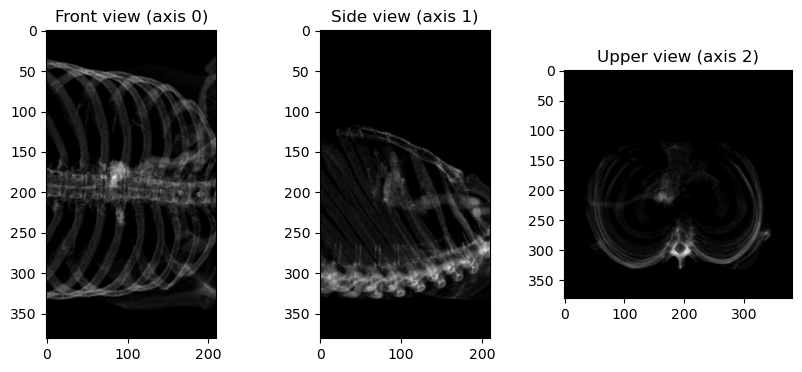

In [24]:
# Example 1- Show the volume with only the 5 largest CC in gray & colors
vol_5_CC = getGrayScaleCC(vol_morph3, 5)
show_volume2D(vol_5_CC)
show_volume3D(vol_5_CC, '5_CC_6.1')

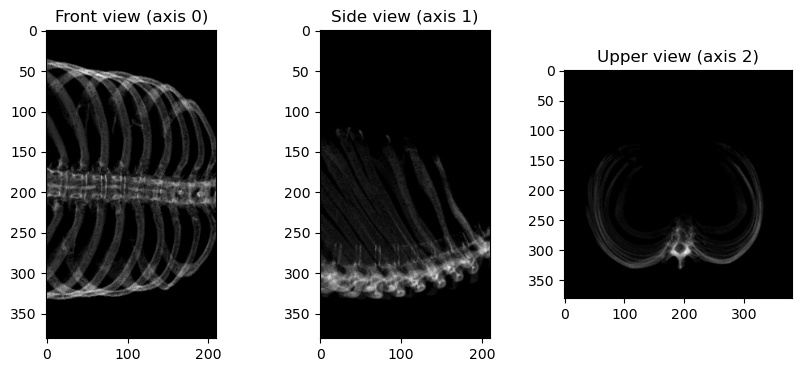

In [25]:
# Example 2- Show the volume with only the largest CC in gray & colors
vol_1_CC = getGrayScaleCC(vol_morph3, 1)
show_volume2D(vol_1_CC)
show_volume3D(vol_5_CC, '1_CC_6.2')

## Final algorithm

In [26]:
def RibCage_Segmentation(p,n):
    
    # Create a volume of patient number (1)
    vol = create_volume(p)
    
    # Filter only the bons on the different axis
    bones_scale_vol = bones_sigmentation(vol)

    # Fix the volum with Morphology by Dilation & Erosion
    vol_morph = Morph(bones_scale_vol)
    
    # Use only the bigest connected components
    vol_CC_morph = getGrayScaleCC(vol_morph, n)
    
    # Show the segmented volume on 2-D
    show_volume2D(vol_CC_morph)

    # Show the segmented volume on 3-D
    show_volume3D(vol_CC_morph, f'ex{p}')

### A few exampels for segmentation the rib cage 

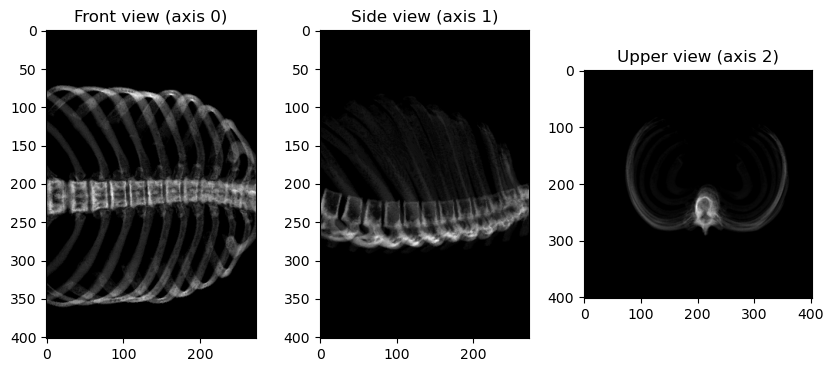

In [27]:
# Patient number 8
RibCage_Segmentation(8,2)

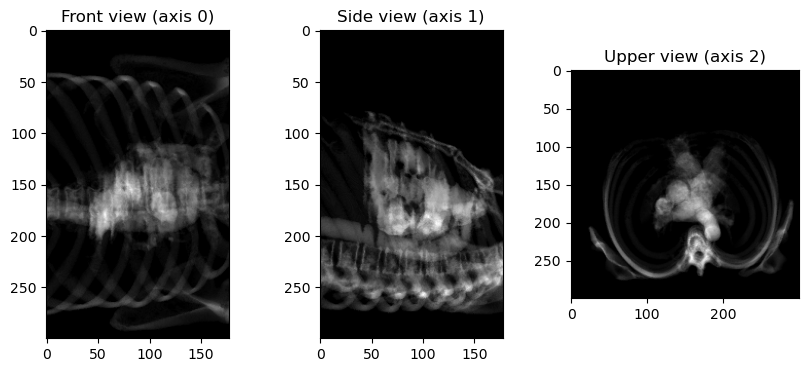

In [28]:
# Patient number 20- Bad example
RibCage_Segmentation(12,1)

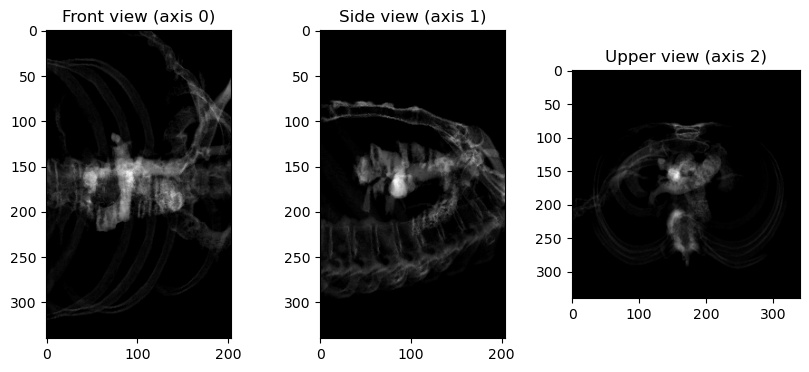

In [29]:
# Patient number 10- Bad example
RibCage_Segmentation(10,3)